# Part II - IBM HR: Employee Attrition Analysis
## by Trevlyin M.I Muzinda

## Investigation Overview

The goal of this analysis is to attain the attrition rate and the possible factors which may give rise or decrease to this rate. We will be focusing on MaritalStaus, JobInvolvement, OverTime, WorkLifeBalance, EnvironmentSatisfaction, and BusinessTravel.

> Attrition is defined by [Gatner](https://www.gartner.com/en/human-resources/glossary/attrition#:~:text=Attrition%20is%20the%20departure%20of,%2C%20termination%2C%20death%20or%20retirement.) as the departure of employees from the organization for any reason (voluntary or involuntary), including resignation, termination, death or retirement. **Attrition rate** is the rate at which employees leave an organization divided by the average number of employees at the organization over a given period of time.mary. 


## Dataset Overview

The HR Employee Attrition dataset is a fictional dataset consisting of 1470 employees, pulled together by IBM specialists and made available through the [data.world](https://data.world/aaizemberg/hr-employee-attrition) platform. It contains information on employees demographic and other situational standings with attrition status.
Some of the ordinal categorical variables in the dataset was given a rating attained from the same author via [Kaggle](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df_hr = pd.read_csv('./HR-Employee-Attrition.tsv.txt', sep='\t')
df_hr.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# Trim down dataset
features = ['Age','Attrition','Gender','MaritalStatus','Department','Education','EnvironmentSatisfaction',
            'BusinessTravel','WorkLifeBalance','OverTime', 'YearsInCurrentRole','YearsWithCurrManager',
            'YearsSinceLastPromotion','PercentSalaryHike', 'NumCompaniesWorked','TrainingTimesLastYear','TotalWorkingYears',
            'JobInvolvement','JobSatisfaction']
analysis_hr = df_hr[features].copy()
analysis_hr.head()

,Age,Attrition,Gender,MaritalStatus,Department,Education,EnvironmentSatisfaction,BusinessTravel,WorkLifeBalance,OverTime,YearsInCurrentRole,YearsWithCurrManager,YearsSinceLastPromotion,PercentSalaryHike,NumCompaniesWorked,TrainingTimesLastYear,TotalWorkingYears,JobInvolvement,JobSatisfaction
0,41,Yes,Female,Single,Sales,2,2,Travel_Rarely,1,Yes,4,5,0,11,8,0,8,3,4
1,49,No,Male,Married,Research & Development,1,3,Travel_Frequently,3,No,7,7,1,23,1,3,10,2,2
2,37,Yes,Male,Single,Research & Development,2,4,Travel_Rarely,3,Yes,0,0,0,15,6,3,7,2,3
3,33,No,Female,Married,Research & Development,4,4,Travel_Frequently,3,Yes,7,0,3,11,1,3,8,3,3
4,27,No,Male,Married,Research & Development,1,1,Travel_Rarely,3,No,2,2,2,12,9,3,6,3,2


In [4]:
analysis_hr[['Attrition','OverTime']] = analysis_hr[['Attrition','OverTime']].replace({'Yes': True, 'No': False})

In [5]:
low_vhigh = {1:'Low',2:'Medium',3:'High',4:'Very High'} # all variables ending with satisfaction and one jobinvolvement
workLife = {1:'Bad',2:'Good',3:'Better',4:'Best'} # for WorkLifeBalance variable
educlass = {1:'Below College',2:'College',3:'Bachelor',4:'Master',5:'Doctor'} # education variable

low_vhigh_vars = ['EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction']

analysis_hr[low_vhigh_vars] = analysis_hr[low_vhigh_vars].replace(low_vhigh)
analysis_hr['WorkLifeBalance'] = analysis_hr['WorkLifeBalance'].replace(workLife)
analysis_hr['Education'] = analysis_hr['Education'].replace(educlass)

In [6]:
# Convert low to very high rated variables into ordered categorical types
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                            categories = ['Low','Medium','High','Very High'])
analysis_hr[low_vhigh_vars] = analysis_hr[low_vhigh_vars].astype(ordered_var)

In [7]:
# convert education and worklifebalance into ordered categorical types
ordinal_var_dict = {'WorkLifeBalance': ['Bad', 'Good', 'Better', 'Best'],
                    'Education': ['Below College', 'College', 'Bachelor','Master','Doctor'],
                    'BusinessTravel': ['Non-Travel','Travel_Rarely','Travel_Frequently']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    analysis_hr[var] = analysis_hr[var].astype(ordered_var)
   

In [8]:
# convert remaining object variables which do not need ordering
object_nominal = analysis_hr.select_dtypes(object)
analysis_hr[object_nominal.columns] = analysis_hr[object_nominal.columns].astype('category')

In [9]:
## Referenced from: https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

def addlabels_top(x,y):
    for i in range(x.min(),(x.min()+len(x))):
        plt.text(i, y[i]+2, y[i], ha = 'center') # add bar labels with padding

In [36]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]/2, y[i], ha = 'center', color='white')
        
def addlabels_perc(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]/2, round(y[i],2), ha = 'center', color='white')

## Employee Attrition Rate

The attrition rate, the average of employees who became part of the attriton sample, for the 1470 employees is 16% which is an occupancy of 237 employees.

In [11]:
attrition_rates = round(analysis_hr['Attrition'].value_counts(normalize=True),2)
attrition_rates[True]

0.16

In [12]:
attrition_count = analysis_hr['Attrition'].value_counts()

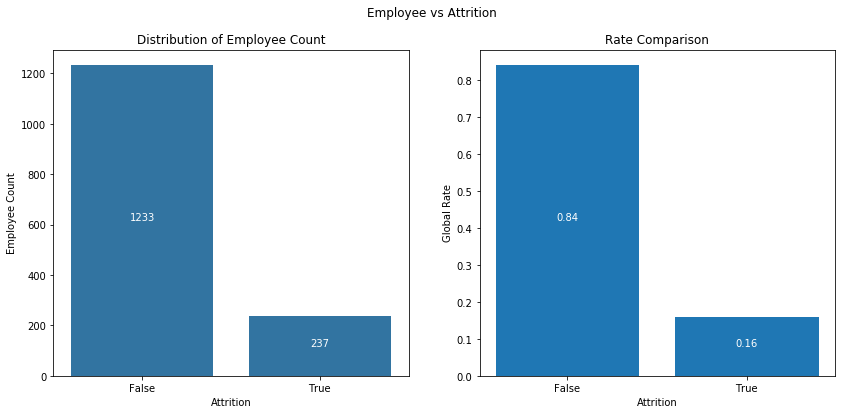

In [37]:
plt.figure(figsize=(14,6))
plt.suptitle('Employee vs Attrition')

plt.subplot(1,2,1)
sb.countplot(data=analysis_hr, x='Attrition', color=sb.color_palette()[0])
addlabels(analysis_hr['Attrition'].unique(), attrition_count)
plt.ylabel('Employee Count')
plt.xlabel('Attrition')
plt.title('Distribution of Employee Count');

plt.subplot(1,2,2)
plt.bar(attrition_rates.index, attrition_rates)
addlabels(analysis_hr['Attrition'].unique(), attrition_rates)
plt.xlabel('Attrition')
plt.ylabel('Global Rate')
plt.xticks([0,1],attrition_rates.index)
plt.title('Rate Comparison');

## Marital Status vs Attrition

Within the dataset the dominant or high risk attrition group are Single Employees which are 32% of Employees. Among the Single Employees they highlighted a large attrition group mean of **25.53%**,*~205% and ~253%* increase compared to its counterparts Married and Divorced respectively. Hence, keeping in mind the global rate being 16%, the Single employee group have an attrition risk of **~1.60** *(25.53/16)* resulting in high risk for attrition. The latter Married and Divorced employees are at low risk of attrition as their risks are lower than 1.

In [45]:
def max_spotlight(df):
    
    max_color = ['grey' if (x < df.max()) else sb.color_palette()[3] for x in df]
    return max_color

In [55]:
# categorical group attrition means
df_ms = analysis_hr.groupby('MaritalStatus')['Attrition'].mean() * 100
df_env = analysis_hr.groupby('EnvironmentSatisfaction')['Attrition'].mean() * 100
df_travel = analysis_hr.groupby('BusinessTravel')['Attrition'].mean() * 100
df_workLife = analysis_hr.groupby('WorkLifeBalance')['Attrition'].mean() * 100
df_ot = analysis_hr.groupby('OverTime')['Attrition'].mean() * 100
df_involved = analysis_hr.groupby('JobInvolvement')['Attrition'].mean() * 100

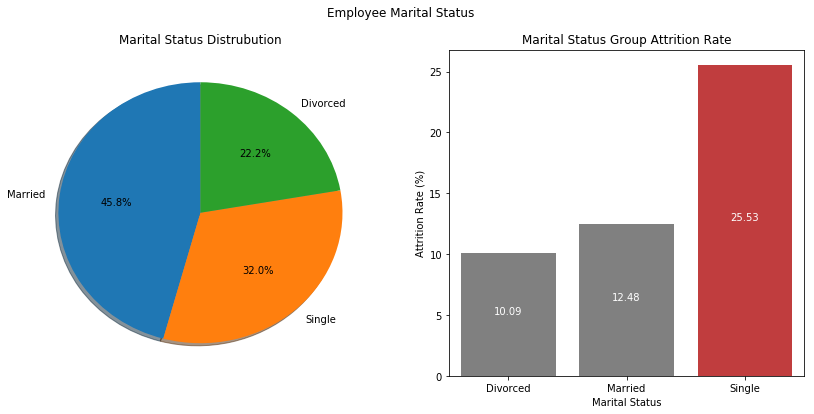

In [54]:
plt.figure(figsize=(14,6))
plt.suptitle('Employee Marital Status')

# MaritalStatus piechart
plt.subplot(1,2,1)
marital_perc = analysis_hr['MaritalStatus'].value_counts(normalize=True)
plt.pie(marital_perc, labels=marital_perc.index,autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Marital Status Distrubution');

plt.subplot(1,2,2)
sb.barplot(x=df_ms.index, y=df_ms, palette=max_spotlight(df_ms.sort_values()))
plt.title('Marital Status Group Attrition Rate')
plt.ylabel('Attrition Rate (%)')
plt.xlabel('Marital Status')
addlabels_perc(df_ms.index,df_ms);

## EnvironmentSatisfaction vs Attrition Rate

Environment satisfaction presents a negative correlation as seen on the figure to the right, the higher the satisfaction rating the lower the risk for employees to be part of the attrition sample. Employees who rated a low satisfaction for their environment are seen to have an attrition rate of **25.35%**, a 2 times increase compared to other ratings, also resulting in high attrition risk.

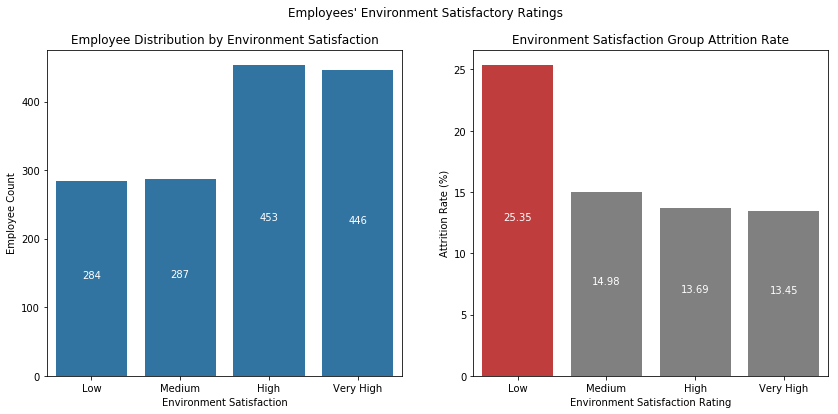

In [56]:
plt.figure(figsize=(14,6))
plt.suptitle("Employees' Environment Satisfactory Ratings")

plt.subplot(1,2,1)
sb.countplot(data=analysis_hr, x='EnvironmentSatisfaction', color=sb.color_palette()[0])
plt.ylabel('Employee Count')
plt.xlabel('Environment Satisfaction')
addlabels(analysis_hr['EnvironmentSatisfaction'].unique(), analysis_hr['EnvironmentSatisfaction'].value_counts())
plt.title('Employee Distribution by Environment Satisfaction');

plt.subplot(1,2,2)
sb.barplot(x=df_env.index, y=df_env, palette=max_spotlight(df_env))
plt.ylabel('Attrition Rate (%)')
plt.xlabel('Environment Satisfaction Rating')
plt.title('Environment Satisfaction Group Attrition Rate')
addlabels_perc(df_env.index,df_env);

## BusinessTravel vs Attrition Rate

1043(**71%**) employees travel rarely, 277(**18.8%**) of them travel frequently and only 150(**10.2%**) of them do not travel for business in their current positions. Among the 18.8% who travel frequently, seems to have a positive effect/correlation on the average attrition rate for the group. As seen from Non-Travel employees have an 8% chance to leave the company which is 2 times less likely than any other employees. Employees who Travel_Rarely have a 1.87 times increase of being part of the attrition sample compared to its first counterpart. An attrition mean which resulted to be the highest in the group with **24.91%** and qualifies as high risk, are employees with an approximate of 156% increased likelihood to be part of the attrition sample Travel_Frequently than the rest.

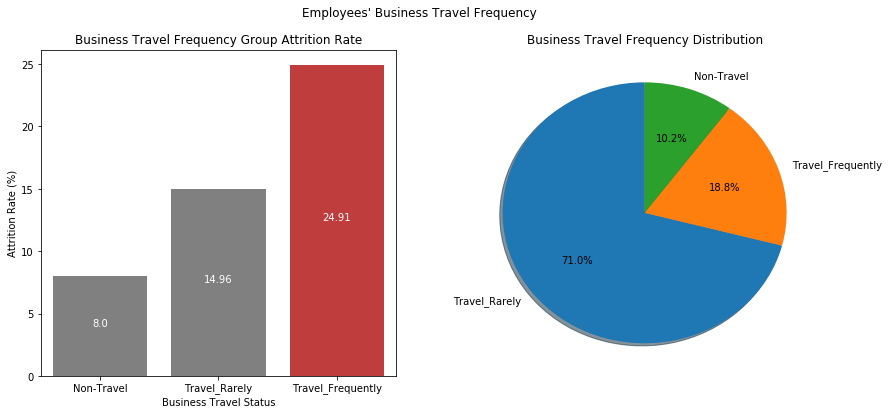

In [57]:
plt.figure(figsize=(14,6))
plt.suptitle("Employees' Business Travel Frequency")

plt.subplot(1,2,2)
# BusinessTravel piechart
businessTravel_perc = analysis_hr['BusinessTravel'].value_counts(normalize=True)
plt.pie(businessTravel_perc, labels=businessTravel_perc.index,autopct='%1.1f%%',
        shadow=True, startangle=90);
plt.title('Business Travel Frequency Distribution');

plt.subplot(1,2,1)
sb.barplot(x=df_travel.index, y=df_travel, palette=max_spotlight(df_travel))
plt.ylabel('Attrition Rate (%)')
plt.xlabel('Business Travel Status')
plt.title('Business Travel Frequency Group Attrition Rate')
addlabels_perc(df_travel.index, df_travel);

## OverTime vs Attrition Rate

Among the 416 employees who work over-time, the group has significantly a higher attrition rate of **30.53%** compared to the **10.44%** of the employees who do not. Hence employees who tend to work past standard hours have a higher attrition risk than those who do not.

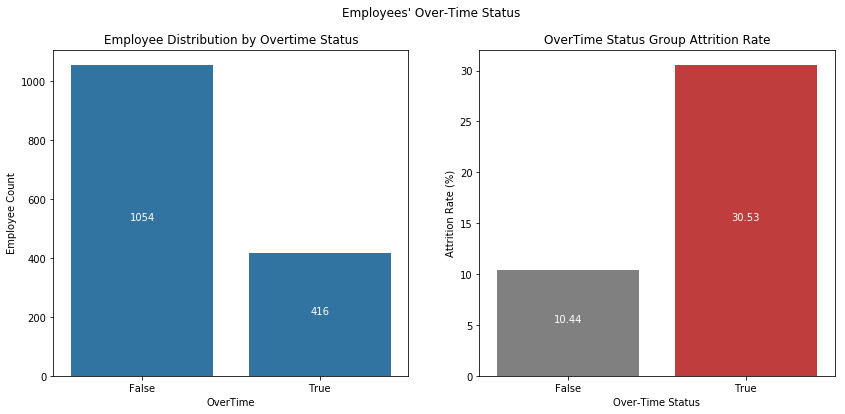

In [64]:
plt.figure(figsize=(14,6))
plt.suptitle("Employees' Over-Time Status")

plt.subplot(1,2,1)
sb.countplot(data=analysis_hr, x='OverTime', color=sb.color_palette()[0])
plt.ylabel('Employee Count')
plt.xlabel('OverTime')
addlabels(analysis_hr['OverTime'].unique(), analysis_hr['OverTime'].value_counts())
plt.title('Employee Distribution by Overtime Status');

plt.subplot(1,2,2)
sb.barplot(x=df_ot.index, y=df_ot, palette=max_spotlight(df_ot))
plt.ylabel('Attrition Rate (%)')
plt.xlabel('Over-Time Status')
plt.title('OverTime Status Group Attrition Rate')
addlabels_perc(df_ot.index, df_ot);

## Job Involvement vs Attrition Rate

Most employees accounting for 868 employees tend to have a high job involvement, 375 have medium, 144 employees are very involved in their job roles, and a low involvement is only partaken by 83 employees. It follows a  negatively correlated relationship with Attrition Rate where the more involved the employees are in their job, the less likely they are to contribute to the attrition rate. The 868 employees who have Low involvement have a higher risk of **33.73%** attrition rate while those who have Medium and High involvement tend to have the same risk as the rest of the employees. Employees who have Very High job involvement have a low risk which is ~1.78% lower than the global rate.

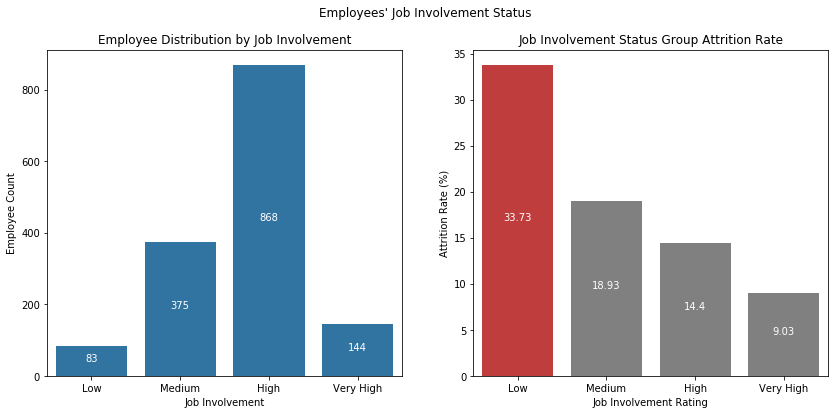

In [65]:
plt.figure(figsize=(14,6))
plt.suptitle("Employees' Job Involvement Status")

plt.subplot(1,2,1)
sb.countplot(data=analysis_hr, x='JobInvolvement', color=sb.color_palette()[0])
plt.ylabel('Employee Count')
plt.xlabel('Job Involvement')
addlabels(analysis_hr['JobInvolvement'].unique(), analysis_hr['JobInvolvement'].value_counts())
plt.title('Employee Distribution by Job Involvement');

plt.subplot(1,2,2)
sb.barplot(x=df_involved.index, y=df_involved, palette=max_spotlight(df_involved))
plt.ylabel('Attrition Rate (%)')
plt.xlabel('Job Involvement Rating')
plt.title('Job Involvement Status Group Attrition Rate')
addlabels_perc(df_involved.index, df_involved);

## Work-Life Balance vs Attrition Rate

The WorkLifeBalance vs Attrition mean resembles an unusual distribution where going up in work-life balance ratings the mean was decreasing, till we got to the Best rating where a sudden raise occured surpassing the Good rating by 0.79%. The Bad rating had an attrition rate of **31.25%** employees within this group.

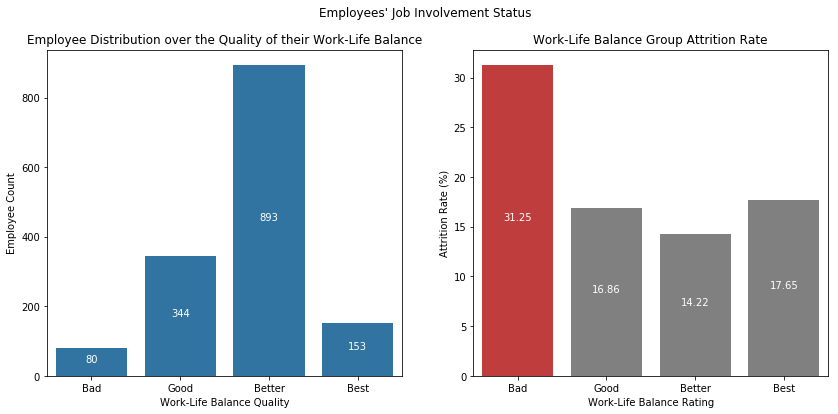

In [85]:
plt.figure(figsize=(14,6))
plt.suptitle("Employees' Job Involvement Status")

plt.subplot(1,2,1)
sb.countplot(data=analysis_hr, x='WorkLifeBalance', color=sb.color_palette()[0])
plt.ylabel('Employee Count')
plt.xlabel('Work-Life Balance Quality')
addlabels(analysis_hr['WorkLifeBalance'].unique(), analysis_hr['WorkLifeBalance'].value_counts())
plt.title('Employee Distribution over the Quality of their Work-Life Balance');

plt.subplot(1,2,2)
sb.barplot(x=df_workLife.index, y=df_workLife, palette=max_spotlight(df_workLife))
plt.ylabel('Attrition Rate (%)')
plt.xlabel('Work-Life Balance Rating')
plt.title('Work-Life Balance Group Attrition Rate')
addlabels_perc(df_workLife.index, df_workLife);

## Improving Work-Life Balance

After isolating features to find factors for the unusual distribution of work-life balance ratings to attrition rate, the 'best' work-life balance large attrition rates for the employees who are **frequent travellers and have low environment satisfaction**, raised suspicion on if they were the cause. Filtering the criteria out and replotting the `WorkLifeBalance` vs `Attrition` resolved the distribution into a negatively correlated outcome and shows that cutting down amount of travel and improving their work environment will reduce attrition rate as follows:
- Bad work-life balance: **-7.25%**
- Good work-life balance: **-2.86%**
- Better work-life balance: **-3.22%**
- Best work-life balance: **-9.65%**

Hence it suggests that improving the working environment and giving employees less business travel will significantly lower the global attrition rate from 16% to 11.98% which is ~4% decrease. A demographic to focus on which gives almost twice the attrition risk are Single Employees.

In [72]:
mask_a = analysis_hr['BusinessTravel'] != 'Travel_Frequently'
mask_b = analysis_hr['EnvironmentSatisfaction'] != 'Low'
masked_hr = analysis_hr.query('@mask_a and @mask_b')

wl_attr = round(masked_hr.groupby('WorkLifeBalance')['Attrition'].mean() *100, 2)

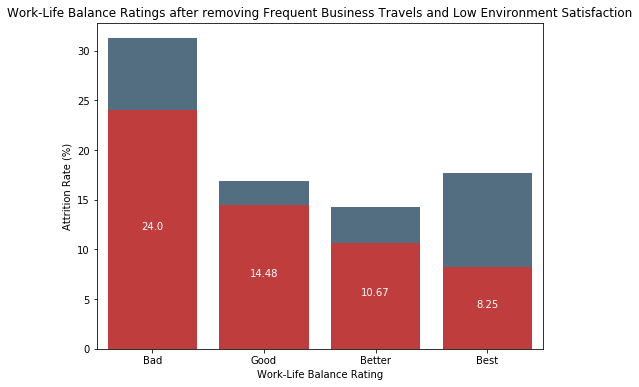

In [83]:
plt.figure(figsize=(8,6))
sb.barplot(x=df_workLife.index, y=df_workLife, color=sb.color_palette()[0], saturation=0.3)
sb.barplot(x=wl_attr.index,y=wl_attr, ci=None, color=sb.color_palette()[3])
addlabels(wl_attr.index,wl_attr)
plt.ylabel('Attrition Rate (%)')
plt.xlabel('Work-Life Balance Rating')
plt.title('Work-Life Balance Ratings after removing Frequent Business Travels and Low Environment Satisfaction', wrap=True);

In [84]:
masked_hr.Attrition.mean()

0.11983471074380166

### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [ ]:
# Use this command if you are running this file in local
!jupyter nbconvert <Part_II_Filename>.ipynb --to slides --post serve --no-input --no-prompt